# CartoonGAN implementation for ATML mini project
##by I059 - Soham Singhal, I074 - Rohit Raval, I083 - Khushal Sharma

##Import Libraries

In [11]:
import os
import shutil
import urllib.request
import torch
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import random_split
import math
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch import sigmoid
import torch
from torchvision import models
from torchvision import models
from torch.nn import BCELoss
import matplotlib.pyplot as plt
from os import listdir
import time
import torch.optim as optim
import os
from PIL import Image
from itertools import cycle
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
from google.colab import drive
drive.mount('/content/data')

Mounted at /content/data


## Load Data

###Extract data

In [5]:
!wget --no-check-certificate 'https://drive.google.com/uc?export=download&id=1w-rAZf3tlXyqP3WmbEgczq7p01jT62Sf' -o cartooGAN.zip

In [19]:
import zipfile
zip_path = 'ATML_CartoonGAN_dataset.zip'
extract_to = 'cartoonGAN/dataset/'

if not os.path.exists(extract_to):
    os.makedirs(extract_to)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

In [12]:
def get_image_paths_from_directory(directory):
    supported_extensions = ['jpg', 'jpeg', 'png', 'gif', 'bmp', 'tiff']
    image_paths = [os.path.join(directory, f) for f in os.listdir(directory)
                   if os.path.isfile(os.path.join(directory, f)) and
                   f.split('.')[-1].lower() in supported_extensions]
    return image_paths

In [13]:
photo_image_paths = get_image_paths_from_directory('cartoonGAN/dataset/train_photo')
smoothed_cartoon_image_paths = get_image_paths_from_directory('cartoonGAN/dataset/Hayao/smooth')
cartoon_image_paths = get_image_paths_from_directory('cartoonGAN/dataset/Hayao/style')
photo_image_paths_valid = get_image_paths_from_directory('cartoonGAN/dataset/val')

In [14]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from itertools import cycle

image_size = 256
batch_size = 16

class CustomDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
        self.original_length = len(image_paths)

    def __len__(self):
        # This will be the size of the largest dataset
        return self.max_length

    def set_max_length(self, max_length):
        self.max_length = max_length

    def __getitem__(self, idx):
        # Cycle through the list if the index is beyond the original length
        image_path = self.image_paths[idx % self.original_length]
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Now, when you create the dataset, you'll set the maximum length after instantiation
max_dataset_length = max(len(photo_image_paths), len(smoothed_cartoon_image_paths), len(cartoon_image_paths))

# Create datasets and set max length for each
photo_dataset_train = CustomDataset(photo_image_paths, transform)
photo_dataset_train.set_max_length(max_dataset_length)
smoothed_cartoon_dataset_train = CustomDataset(smoothed_cartoon_image_paths, transform)
smoothed_cartoon_dataset_train.set_max_length(max_dataset_length)
cartoon_dataset_train = CustomDataset(cartoon_image_paths, transform)
cartoon_dataset_train.set_max_length(max_dataset_length)

# Now create the dataloaders as before, but without the need to cycle images
photo_dataloader_train = DataLoader(photo_dataset_train, batch_size=batch_size, shuffle=True)
smoothed_cartoon_image_dataloader_train = DataLoader(smoothed_cartoon_dataset_train, batch_size=batch_size, shuffle=True)
cartoon_image_dataloader_train = DataLoader(cartoon_dataset_train, batch_size=batch_size, shuffle=True)

In [15]:
photo_valid = CustomDataset(photo_image_paths_valid, transform)
photo_valid.set_max_length(len(photo_image_paths_valid))
photo_dataloader_valid = DataLoader(photo_valid, batch_size=batch_size, shuffle=False)

###Generator

In [16]:
class ResidualBlock(nn.Module):
  def __init__(self):
    super(ResidualBlock, self).__init__()
    self.conv_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.norm_1 = nn.BatchNorm2d(256)
    self.norm_2 = nn.BatchNorm2d(256)

  def forward(self, x):
    output = self.norm_2(self.conv_2(F.relu(self.norm_1(self.conv_1(x)))))
    return output + x #ES

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)
      self.norm_1 = nn.BatchNorm2d(64)

      # down-convolution #
      self.conv_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
      self.conv_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.norm_2 = nn.BatchNorm2d(128)

      self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
      self.conv_5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
      self.norm_3 = nn.BatchNorm2d(256)

      # residual blocks #
      residualBlocks = []
      for l in range(8):
        residualBlocks.append(ResidualBlock())
      self.res = nn.Sequential(*residualBlocks)

      # up-convolution #
      self.conv_6 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
      self.conv_7 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.norm_4 = nn.BatchNorm2d(128)

      self.conv_8 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
      self.conv_9 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
      self.norm_5 = nn.BatchNorm2d(64)

      self.conv_10 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
      x = F.relu(self.norm_1(self.conv_1(x)))

      x = F.relu(self.norm_2(self.conv_3(self.conv_2(x))))
      x = F.relu(self.norm_3(self.conv_5(self.conv_4(x))))

      x = self.res(x)
      x = F.relu(self.norm_4(self.conv_7(self.conv_6(x))))
      x = F.relu(self.norm_5(self.conv_9(self.conv_8(x))))

      x = self.conv_10(x)

      x = sigmoid(x)

      return x

In [17]:
G = Generator()
print(G)

Generator(
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res): Sequential(
    (0): ResidualBlock(
      (conv_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

### Discriminator

In [18]:
class Discriminator(nn.Module):
  def __init__(self):
     super(Discriminator, self).__init__()
     self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)

     self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
     self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
     self.norm_1 = nn.BatchNorm2d(128)

     self.conv_4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)
     self.conv_5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
     self.norm_2 = nn.BatchNorm2d(256)

     self.conv_6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
     self.norm_3 = nn.BatchNorm2d(256)

     self.conv_7 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    x = F.leaky_relu(self.conv_1(x))
    x = F.leaky_relu(self.norm_1(self.conv_3(F.leaky_relu(self.conv_2(x)))), negative_slope=0.2)
    x = F.leaky_relu(self.norm_2(self.conv_5(F.leaky_relu(self.conv_4(x)))), negative_slope=0.2)
    x = F.leaky_relu(self.norm_3(self.conv_6(x)), negative_slope=0.2)
    x = self.conv_7(x)
    x = sigmoid(x)

    return x

In [19]:
D = Discriminator()
print(D)

Discriminator(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_7): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### use device CPU or GPU

In [20]:
device = torch.device('cpu')

if torch.cuda.is_available():
  device = torch.device('cuda')
  print("Train on GPU.")
else:
  print("No cuda available")

G.to(device)
D.to(device)

No cuda available


Discriminator(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_7): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

### VGG-16
Load already downloaded vgg-16 weights from drive, or download and save to drive.

In [23]:
!wget -O vgg16-397923af.pth 'https://download.pytorch.org/models/vgg16-397923af.pth'

--2023-11-07 10:39:53--  https://download.pytorch.org/models/vgg16-397923af.pth
Resolving download.pytorch.org (download.pytorch.org)... 108.159.15.89, 108.159.15.86, 108.159.15.96, ...
Connecting to download.pytorch.org (download.pytorch.org)|108.159.15.89|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 553433881 (528M) [binary/octet-stream]
Saving to: ‘vgg16-397923af.pth’

vgg16-397923af.pth  100%[===================>] 527.79M  56.5MB/s    in 8.9s    

2023-11-07 10:40:02 (59.5 MB/s) - ‘vgg16-397923af.pth’ saved [553433881/553433881]



In [24]:
path_to_pretrained_vgg16 = 'vgg16-397923af.pth'

try:
  pretrained = torch.load(path_to_pretrained_vgg16)
  vgg16 = models.vgg16(pretrained=False)
  vgg16.load_state_dict(pretrained)
  vgg16 = vgg16.to(device)
except FileNotFoundError:
  vgg16 = models.vgg16(pretrained=True)
  torch.save(vgg16, path_to_pretrained_vgg16)
  vgg16 = vgg16.to(device)
print(vgg16)

feature_extractor = vgg16.features[:24]
for param in feature_extractor.parameters():
  param.require_grad = False

print(feature_extractor)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Two loss functions

- discriminator loss
- generator initialization phase loss and generator loss

In [25]:
class DiscriminatorLoss(torch.nn.Module):
  def __init__(self):
      super(DiscriminatorLoss, self).__init__()
      self.bce_loss = BCELoss()

  def forward(self, discriminator_output_of_cartoon_input,
              discriminator_output_of_cartoon_smoothed_input,
              discriminator_output_of_generated_image_input,
              epoch,
              write_to_tensorboard=False):

    return self._adversarial_loss(discriminator_output_of_cartoon_input,
                     discriminator_output_of_cartoon_smoothed_input,
                     discriminator_output_of_generated_image_input,
                     epoch,
                     write_to_tensorboard)

  def _adversarial_loss(self, discriminator_output_of_cartoon_input,
                     discriminator_output_of_cartoon_smoothed_input,
                     discriminator_output_of_generated_image_input,
                     epoch,
                     write_to_tensorboard):

    # define ones and zeros here instead within __init__ due to have same shape as input
    # due to testing different batch_sizes, sometimes the "last batch" has < batch_size elements
    actual_batch_size = discriminator_output_of_cartoon_input.size()[0]
    zeros = torch.zeros([actual_batch_size, 1, 64, 64]).to(device)
    ones = torch.ones([actual_batch_size, 1, 64, 64]).to(device)

    d_loss_cartoon = self.bce_loss(discriminator_output_of_cartoon_input, ones)
    d_loss_cartoon_smoothed = self.bce_loss(discriminator_output_of_cartoon_smoothed_input, zeros)
    d_loss_generated_input = self.bce_loss(discriminator_output_of_generated_image_input, zeros)

    d_loss = d_loss_cartoon + d_loss_cartoon_smoothed + d_loss_generated_input

    return d_loss

In [26]:
class GeneratorLoss(torch.nn.Module):
  def __init__(self):
      super(GeneratorLoss, self).__init__()
      self.w = 0.000005
      self.bce_loss = BCELoss()
      self.feature_extractor = vgg16.features[:24]
      for param in self.feature_extractor.parameters():
        param.require_grad = False

  def forward(self, discriminator_output_of_generated_image_input,
              generator_input,
              generator_output,
              epoch,
              is_init_phase=False,
              write_to_tensorboard=False):
    if is_init_phase:
      g_content_loss = self._content_loss(generator_input, generator_output)
      g_adversarial_loss = 0.0
      g_loss = g_content_loss
    else:
      g_adversarial_loss = self._adversarial_loss_generator_part_only(discriminator_output_of_generated_image_input)
      g_content_loss = self._content_loss(generator_input, generator_output)
      g_loss = g_adversarial_loss + self.w * g_content_loss

    return g_loss

  def _adversarial_loss_generator_part_only(self, discriminator_output_of_generated_image_input):
    actual_batch_size = discriminator_output_of_generated_image_input.size()[0]
    ones = torch.ones([actual_batch_size, 1, 64, 64]).to(device)
    return self.bce_loss(discriminator_output_of_generated_image_input, ones)

  def _content_loss(self, generator_input, generator_output):
    return (self.feature_extractor(generator_output) - self.feature_extractor(generator_input)).norm(p=1)

In [27]:
discriminatorLoss = DiscriminatorLoss()
generatorLoss = GeneratorLoss()

## Optimizer

In [28]:
lr = 0.002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [40]:
!mkdir /content/cartoonGAN/checkpoints/
!mkdir -p /content/cartoonGAN/intermediate_results/training/
intermediate_results_training_path = "cartoonGAN/intermediate_results/training/"

mkdir: cannot create directory ‘/content/cartoonGAN/checkpoints/’: No such file or directory


In [29]:
intermediate_results_training_path = "cartoonGAN/intermediate_results/training/"

In [30]:
def save_training_result(input, output, epoch):
  # input/output has batch-size number of images, get first one and detach from tensor
  image_input = input[0].detach().cpu().numpy()
  image_output = output[0].detach().cpu().numpy()
  # transponse image from torch.Size([3, 256, 256]) to (256, 256, 3)
  image_input = np.transpose(image_input, (1, 2, 0))
  image_output = np.transpose(image_output, (1, 2, 0))

  # generate filenames as timestamp, this orders the output by time
  filename = str(int(time.time()))
  path_input = intermediate_results_training_path + filename +"_epoch"+str(epoch)+ "_input.jpg"
  path_output = intermediate_results_training_path + filename +"_epoch"+str(epoch)+ ".jpg"
  plt.imsave(path_input, image_input)
  plt.imsave(path_output, image_output)

## Training

In [31]:
def train(_num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses):
    init_epochs = 7
    print_every = 100
    start_time = time.time()

    for epoch in range(_num_epochs - epochs_already_done):
        epoch = epoch + epochs_already_done

        for index, (photo_images,  smoothed_cartoon_images, cartoon_images) in enumerate(zip(photo_dataloader_train, smoothed_cartoon_image_dataloader_train, cartoon_image_dataloader_train)):
            batch_size = photo_images.size(0)
            photo_images = photo_images.to(device)
            smoothed_cartoon_images = smoothed_cartoon_images.to(device)
            cartoon_images = cartoon_images.to(device)

      # train the discriminator
            if epoch % 3 == 0:
                # train the discriminator
                d_optimizer.zero_grad()

                d_of_cartoon_input = D(cartoon_images)
                d_of_cartoon_smoothed_input = D(smoothed_cartoon_images)
                d_of_generated_image_input = D(G(photo_images))

                d_loss = discriminatorLoss(d_of_cartoon_input,
                                            d_of_cartoon_smoothed_input,
                                            d_of_generated_image_input,
                                            epoch,
                                            write_to_tensorboard=(index == 0))

                d_loss.backward()
                d_optimizer.step()
            else:
                # Skip discriminator update, just calculate the loss for logging
                with torch.no_grad():
                    d_of_cartoon_input = D(cartoon_images)
                    d_of_cartoon_smoothed_input = D(smoothed_cartoon_images)
                    d_of_generated_image_input = D(G(photo_images))
                    d_loss = discriminatorLoss(d_of_cartoon_input,
                                               d_of_cartoon_smoothed_input,
                                               d_of_generated_image_input,
                                               epoch,
                                               write_to_tensorboard=(index == 0))

            # train the generator
            g_optimizer.zero_grad()
            g_output = G(photo_images)
            d_of_generated_image_input = D(g_output)

            init_phase = epoch < init_epochs
            g_loss = generatorLoss(d_of_generated_image_input,
                                   photo_images,
                                   g_output,
                                   epoch,
                                   is_init_phase=init_phase,
                                   write_to_tensorboard=(index == 0))

            g_loss.backward()
            g_optimizer.step()

            # Logging
            if (index % print_every) == 0:
                losses.append((d_loss.item(), g_loss.item()))
                now = time.time()
                current_run_time = now - start_time
                start_time = now
                print(f"Epoch {epoch+1}/{_num_epochs} | d_loss {d_loss.item():6.4f} | g_loss {g_loss.item():6.4f} | time {current_run_time:2.0f}s | total no. of losses {len(losses)}")


        if (epoch%10 == 0):
            save_training_result(photo_images, g_output, epoch)

    # validate
        with torch.no_grad():
            D.eval()
            G.eval()

            for batch_index, (photo_images) in enumerate(photo_dataloader_valid):
                photo_images = photo_images.to(device)

                g_output = G(photo_images)
                d_of_generated_image_input = D(g_output)
                g_valid_loss = generatorLoss(d_of_generated_image_input,
                                              photo_images,
                                              g_output,
                                              epoch,
                                              is_init_phase=init_phase,
                                              write_to_tensorboard=False)

            if batch_index % print_every == 0:
                validation_losses.append(g_valid_loss.item())
                now = time.time()
                current_run_time = now - start_time
                start_time = now
                print("Epoch {}/{} | validation loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, g_valid_loss.item(), current_run_time, len(validation_losses)))

        D.train()
        G.train()

        if(g_valid_loss.item() < best_valid_loss):
            print("Generator loss improved from {} to {}".format(best_valid_loss, g_valid_loss.item()))
            best_valid_loss = g_valid_loss.item()

    # save checkpoint
        checkpoint = {'g_valid_loss': g_valid_loss.item(),
                      'best_valid_loss': best_valid_loss,
                      'losses': losses,
                      'validation_losses': validation_losses,
                      'last_epoch': epoch+1,
                      'd_state_dict': D.state_dict(),
                      'g_state_dict': G.state_dict(),
                      'd_optimizer_state_dict': d_optimizer.state_dict(),
                      'g_optimizer_state_dict': g_optimizer.state_dict()
                    }
    #print("Save checkpoint for validation loss of {}".format(g_valid_loss.item()))
    #torch.save(checkpoint, checkpoint_dir + '/checkpoint_epoch_{:03d}.pth'.format(epoch+1))
        if(best_valid_loss == g_valid_loss.item()):
            print("Overwrite best checkpoint")
            torch.save(checkpoint, checkpoint_dir + '/best_checkpoint_hayao.pth')

    return losses, validation_losses

In [32]:
checkpoint_dir = 'cartoonGAN/checkpoints_hayao'
checkpoints = listdir(checkpoint_dir)
num_epochs = 200 + 10 # training + init phase
epochs_already_done = 0
best_valid_loss = math.inf
losses = []
validation_losses = []

if(len(checkpoints) > 0):
    last_checkpoint = sorted(checkpoints)[-1]
    checkpoint = torch.load(checkpoint_dir + '/' + last_checkpoint, map_location=torch.device(device))
    best_valid_loss = checkpoint['best_valid_loss']
    epochs_already_done = checkpoint['last_epoch']
    losses = checkpoint['losses']
    validation_losses = checkpoint['validation_losses']

    D.load_state_dict(checkpoint['d_state_dict'])
    G.load_state_dict(checkpoint['g_state_dict'])
    d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
    g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
    print('Load checkpoint {} with g_valid_loss {}, best_valid_loss {}, {} epochs and total no of losses {}'.format(last_checkpoint, checkpoint['g_valid_loss'], best_valid_loss, epochs_already_done, len(losses)))


Load checkpoint best_checkpoint_hayao.pth with g_valid_loss 0.11391903460025787, best_valid_loss 0.11391903460025787, 26 epochs and total no of losses 130


In [ ]:
losses, validation_losses = train(num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses)

Epoch 26/210 | d_loss 2.7866 | g_loss 0.5573 | time  0s | total no. of losses 126
Epoch 26/210 | d_loss 2.7797 | g_loss 0.4911 | time 35s | total no. of losses 127
Epoch 26/210 | d_loss 2.7866 | g_loss 0.4600 | time 36s | total no. of losses 128
Epoch 26/210 | d_loss 2.7992 | g_loss 0.5509 | time 34s | total no. of losses 129
Epoch 26/210 | d_loss 2.7932 | g_loss 0.4898 | time 34s | total no. of losses 130
Generator loss improved from 0.1750728040933609 to 0.11391903460025787
Overwrite best checkpoint
Epoch 27/210 | d_loss 2.1857 | g_loss 1.7597 | time  7s | total no. of losses 131
Epoch 27/210 | d_loss 2.2203 | g_loss 1.6179 | time 35s | total no. of losses 132
Epoch 27/210 | d_loss 2.2113 | g_loss 1.5833 | time 35s | total no. of losses 133
Epoch 27/210 | d_loss 2.2173 | g_loss 1.6120 | time 35s | total no. of losses 134
Epoch 27/210 | d_loss 2.1864 | g_loss 1.8280 | time 35s | total no. of losses 135
Epoch 28/210 | d_loss 2.2320 | g_loss 1.7034 | time  7s | total no. of losses 136
E

In [39]:
from PIL import Image
input_image_path = "cartoonGAN/dataset/train_photo/0.jpg"  # Replace with the path to your input image
input_image = Image.open(input_image_path)

In [40]:
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the desired input size
    transforms.ToTensor(),  # Convert to a tensor
])
input_tensor = preprocess(input_image).unsqueeze(0)

In [41]:
input_tensor.shape

torch.Size([1, 3, 256, 256])

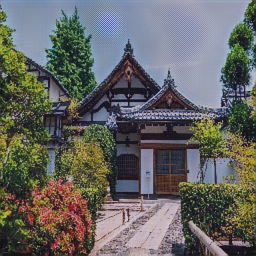

In [42]:
with torch.no_grad():
    generated_image = G(input_tensor)

# Step 4: Convert the generated tensor to a PIL Image
generated_image = transforms.ToPILImage()(generated_image[0])  # Remove the batch dimension

# Step 5: Display the generated image
generated_image.show()

In [44]:
input_image_path = "cartoonGAN/dataset/train_photo/1.jpg"  # Replace with the path to your input image
input_image = Image.open(input_image_path)

In [45]:
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the desired input size
    transforms.ToTensor(),  # Convert to a tensor
])
input_tensor = preprocess(input_image).unsqueeze(0)

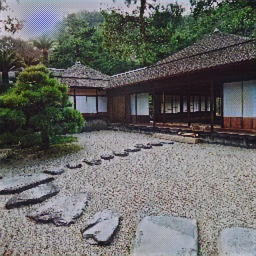

In [46]:
with torch.no_grad():
    generated_image = G(input_tensor)

generated_image = transforms.ToPILImage()(generated_image[0])  # Remove the batch dimension

generated_image.show()

In [47]:
input_image_path = "cartoonGAN/dataset/train_photo/2.jpg"  # Replace with the path to your input image
input_image = Image.open(input_image_path)

In [48]:
preprocess = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the desired input size
    transforms.ToTensor(),  # Convert to a tensor
])
input_tensor = preprocess(input_image).unsqueeze(0)

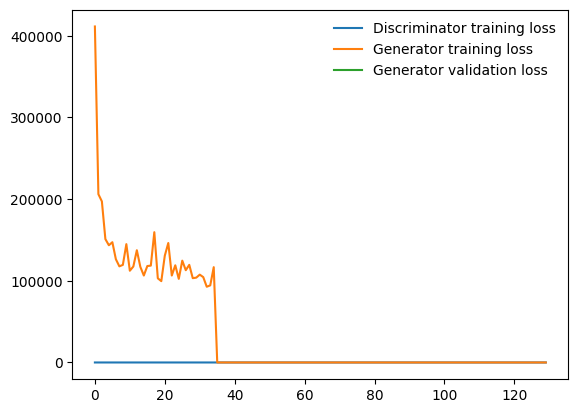

In [33]:
%matplotlib inline
%config InlineBackend.figure.format = 'retina'

d_losses = [x[0] for x in losses]
g_losses = [x[1] for x in losses]
plt.plot(d_losses, label='Discriminator training loss')
plt.plot(g_losses, label='Generator training loss')
plt.plot(validation_losses, label='Generator validation loss')
plt.legend(frameon=False)